In [ ]:
# get the necessary packages
import numpy as np
import scipy as sp
from scipy import sparse
from scipy import linalg
import matplotlib.pyplot as plt
from numpy.polynomial.hermite import hermgauss

In [ ]:
gamma_1 = 0.0001
gamma_2 = 5.0
T = 1.0
a = -1.0
b = +1.0
# define the initial condition
u_0 = lambda x: np.power(x,2)*np.cos(np.pi * x)
# define the Dirichlet BC
u_a = u_b = -1.0

In [ ]:
def run_ieks(dt, dx, sig=10, nell=2, niter=10):
    # the number of spatial grid points
    J = int((b - a)/dx)
    # the number of temporal grid points
    N = int(T/dt)
    # construct the mesh in (t, x)
    x = np.linspace(a, b, J + 1)       # mesh points in space
    t = np.linspace(0, T, N + 1)       # mesh points in time

    ell = nell*dx

    A_dt = np.array([[1,dt],[0,1]])
    Q_dt = np.array([[dt**3/3,dt**2/2],[dt**2/2,dt]])

    I_Jm1 = np.eye(J-1)
    C_Jm1 = np.zeros((J-1,J-1))
    for i in range(0,J-1):
        for j in range(0,J-1):
            C_Jm1[i,j] = sig**2 * np.exp(-(x[i+1] - x[j+1])**2 / (2*ell**2))

    A = np.kron(A_dt,I_Jm1)
    Q = np.kron(Q_dt,C_Jm1)
    H_s = np.kron(np.array([[1,0]]),I_Jm1)
    H_d = np.kron(np.array([[0,1]]),I_Jm1)

    def g(x):
        u = x[:J-1]
        u_jp1 = np.concatenate( (u[1:], np.array([u_b])) )
        u_jm1 = np.concatenate( (np.array([u_a]), u[0:-1]) )
        f = -gamma_1 * (u_jp1 - 2.*u + u_jm1) / (dx * dx) + gamma_2 * (np.power(u,3) - u)
        du = x[J-1:]
        return du + f

    def G_x(x):
        u = x[:J-1]
        G1 = sparse.diags((-gamma_1 * np.ones(J-2) / (dx * dx), gamma_1 * 2.0 * np.ones(J-1) / (dx * dx) + gamma_2 * (3.*np.power(u,2) - np.ones(J-1)), -gamma_1 * np.ones(J-2) / (dx * dx)), (-1,0,1)).toarray()
        G2 = np.eye(J-1)
        return np.concatenate((G1,G2),axis=1)

    nominal = np.empty((N+1, 2 * (J-1)))

    for iter in range(niter):
        # Initialize
        m = np.zeros(2 * (J-1))
        for i in range(0, J-1):
            m[i] = u_0(x[i+1])
            m[i+J-1] = 0

        P = linalg.block_diag( np.zeros((J-1,J-1)), np.eye(J-1) )

        m_list = np.empty((N+1, 2 * (J-1)))
        P_list = np.empty((N+1, 2 * (J-1), 2 * (J-1)))

        m_list[0,:] = m
        P_list[0,:,:] = P

        err = 0

        for n in range(1, N + 1):
            m = A @ m
            P = A @ P @ A.T + Q

            if iter == 0:
                mn = m
            else:
                mn = nominal[n,:]
            G_val = G_x(mn)
            g_val = g(mn) + G_val @ (m - mn)

            S = G_val @ P @ G_val.T
            K = linalg.solve(S, G_val @ P).T

            m = m + K @ (-g_val)

            err = err + np.dot(g_val,g_val)

            B = np.eye(K.shape[0]) - K @ G_val
            P = B @ P @ B.T

            m_list[n,:] = m
            P_list[n,:,:] = P

        err = err / dx / N / J
        print(f"err = {err}")

        ms_list = m_list.copy()
        Ps_list = P_list.copy()
        ms = m_list[-1,:]
        Ps = P_list[-1,:,:]

        u_PS = np.zeros((N + 1, J + 1))
        u_PS_var = np.zeros((N + 1, J + 1))

        u_PS[n,0] = u_a
        u_PS[n,-1] = u_b
        u_PS[n,1:-1] = H_s @ m

        for n in range(N,-1,-1):
            m = m_list[n,:]
            P = P_list[n,:,:]

            mp = A @ m
            Pp = A @ P @ A.T + Q

            Gk = linalg.solve(Pp, A @ P).T
            ms = m + Gk @ (ms - mp)
            Ps = P + Gk @ (Ps - Pp) @ Gk.T

            ms_list[n,:] = ms
            Ps_list[n,:,:] = Ps

            u_PS[n,0] = u_a
            u_PS[n,-1] = u_b
            u_PS[n,1:-1] = H_s @ ms

            u_PS_var[n,0] = 0
            u_PS_var[n,-1] = 0
            u_PS_var[n,1:-1] = np.diag(H_s @ Ps @ H_s.T)

        if iter == 0:
            nominal = ms_list.copy()
        else:
            c = 0.1
            nominal = (1 - c) * nominal + c * ms_list

    return t, x, u_PS, u_PS_var



err = 7.248112702182539
err = 7.8677726588459045
err = 7.691211373141674
err = 7.58469380423354
err = 7.497651624698185
err = 7.4393478028475215
err = 7.475980760941071
err = 7.5948742489888295
err = 7.7167635288066005
err = 7.7766908446856515
dt = 0.05, dx = 0.01


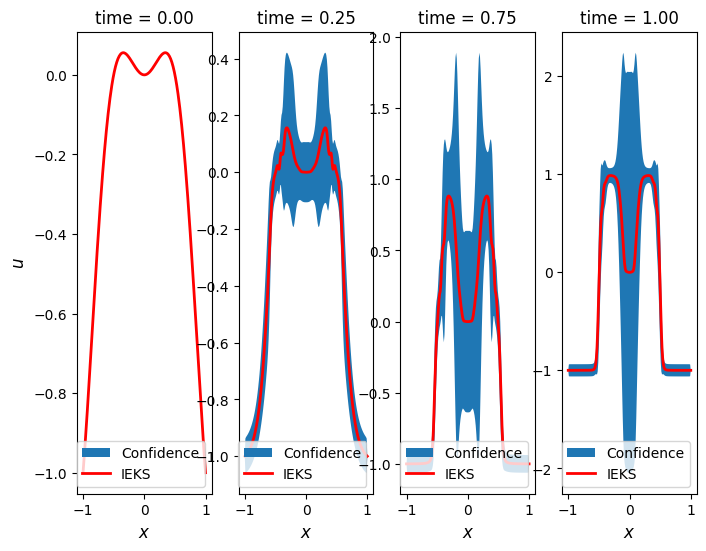

In [ ]:
# Run with a quite rough grid

#ps_frames = [0, 500, 1000, 1500]
#ps_dt = 0.001

#ps_frames = [0, 25, 75, 100]
#ps_dt = 0.01

ps_frames = [0, 5, 15, 20]
ps_dt = 0.05

ps_dx = 0.01

ps_t, ps_x, u_PS, u_PS_var = run_ieks(ps_dt, ps_dx, 10, 2)

print(f"dt = {ps_dt}, dx = {ps_dx}")

# choose the time (frame idx) at which the output is made
# show the side-by-side comparison at different times
fig = plt.figure(figsize = (8, 6))
for idx, frame_idx in enumerate(ps_frames):
    ax = fig.add_subplot(1, 4, idx + 1)
    ax.fill_between(ps_x, u_PS[frame_idx, :] - 1.96 * np.sqrt(u_PS_var[frame_idx, :]), u_PS[frame_idx, :] + 1.96 * np.sqrt(u_PS_var[frame_idx, :]), label = 'Confidence')
    ax.plot(ps_x, u_PS[frame_idx, :], 'r-', linewidth = 2.0, label = 'IEKS')
    ax.set_xlabel('$x$', fontsize = 'large')
    if (idx == 0):
        ax.set_ylabel('$u$', fontsize = 'large')
    ax.set_title(r'time = {:.2f}'.format(ps_t[frame_idx]), fontsize = 'large')
    ax.legend(loc = 'lower right')
plt.show()

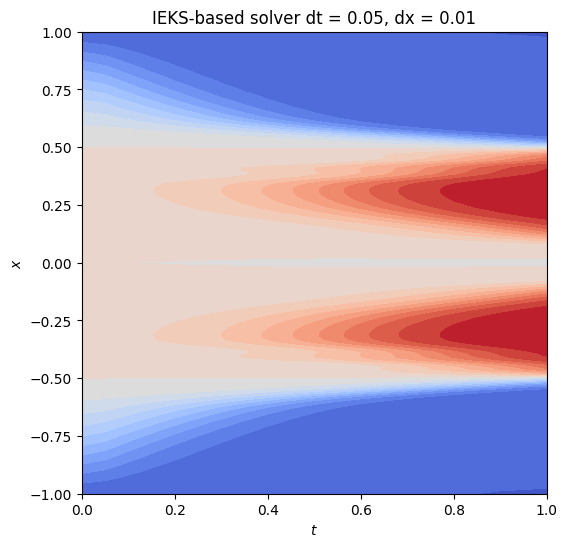

In [ ]:
import matplotlib.ticker as ticker
Ts, Xs = np.meshgrid(ps_t, ps_x)
# plot the PINN solution and comparison at x = 0 and x = 1
fmt = ticker.ScalarFormatter(useMathText=True)
fmt.set_powerlimits((0, 0))
num_cLines = 20
# use contourf to fill in the color
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(1, 1, 1)
ax.contourf(Ts, Xs, u_PS.T, num_cLines, cmap = plt.cm.coolwarm)
ax.set_xlabel('$t$')
ax.set_ylabel('$x$')
ax.set_title(f'IEKS-based solver dt = {ps_dt}, dx = {ps_dx}')
plt.show()

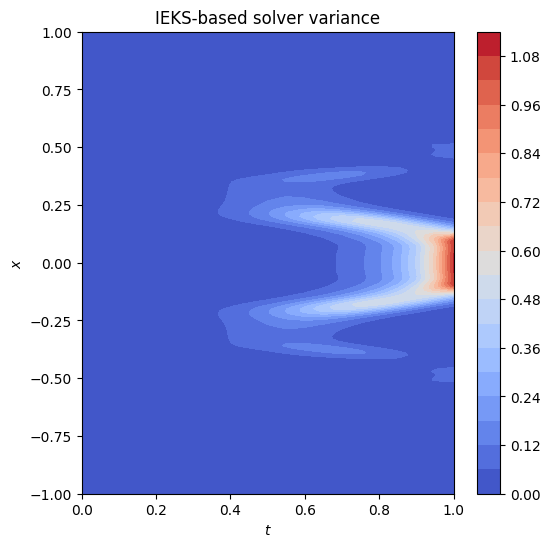

In [ ]:
import matplotlib.ticker as ticker
Ts, Xs = np.meshgrid(ps_t, ps_x)
# plot the PINN solution and comparison at x = 0 and x = 1
fmt = ticker.ScalarFormatter(useMathText=True)
fmt.set_powerlimits((0, 0))
num_cLines = 20
# use contourf to fill in the color
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(1, 1, 1)
im = ax.contourf(Ts, Xs, u_PS_var.T, num_cLines, cmap = plt.cm.coolwarm)
ax.set_xlabel('$t$')
ax.set_ylabel('$x$')
ax.set_title('IEKS-based solver variance')
fig.colorbar(im, orientation='vertical')
plt.show()

In [ ]:
# Run with a quite rough grid

#ps_frames = [0, 500, 1000, 1500]
#ps_dt = 0.001

ps_frames = [0, 25, 75, 100]
ps_dt = 0.01

#ps_frames = [0, 5, 15, 20]
#ps_dt = 0.05

ps_dx = 0.01

ps_t, ps_x, u_PS, u_PS_var = run_ieks(ps_dt, ps_dx, 10, 2)

print(f"dt = {ps_dt}, dx = {ps_dx}")

# choose the time (frame idx) at which the output is made
# show the side-by-side comparison at different times
fig = plt.figure(figsize = (8, 6))
for idx, frame_idx in enumerate(ps_frames):
    ax = fig.add_subplot(1, 4, idx + 1)
    ax.fill_between(ps_x, u_PS[frame_idx, :] - 1.96 * np.sqrt(u_PS_var[frame_idx, :]), u_PS[frame_idx, :] + 1.96 * np.sqrt(u_PS_var[frame_idx, :]), label = 'Confidence')
    ax.plot(ps_x, u_PS[frame_idx, :], 'r-', linewidth = 2.0, label = 'IEKS')
    ax.set_xlabel('$x$', fontsize = 'large')
    if (idx == 0):
        ax.set_ylabel('$u$', fontsize = 'large')
    ax.set_title(r'time = {:.2f}'.format(ps_t[frame_idx]), fontsize = 'large')
    ax.legend(loc = 'lower right')
plt.show()

KeyboardInterrupt: ignored

In [ ]:
import matplotlib.ticker as ticker
Ts, Xs = np.meshgrid(ps_t, ps_x)
# plot the PINN solution and comparison at x = 0 and x = 1
fmt = ticker.ScalarFormatter(useMathText=True)
fmt.set_powerlimits((0, 0))
num_cLines = 20
# use contourf to fill in the color
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(1, 1, 1)
ax.contourf(Ts, Xs, u_PS.T, num_cLines, cmap = plt.cm.coolwarm)
ax.set_xlabel('$t$')
ax.set_ylabel('$x$')
ax.set_title(f'IEKS-based solver dt = {ps_dt}, dx = {ps_dx}')
plt.show()

In [ ]:
import matplotlib.ticker as ticker
Ts, Xs = np.meshgrid(ps_t, ps_x)
# plot the PINN solution and comparison at x = 0 and x = 1
fmt = ticker.ScalarFormatter(useMathText=True)
fmt.set_powerlimits((0, 0))
num_cLines = 20
# use contourf to fill in the color
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(1, 1, 1)
im = ax.contourf(Ts, Xs, u_PS_var.T, num_cLines, cmap = plt.cm.coolwarm)
ax.set_xlabel('$t$')
ax.set_ylabel('$x$')
ax.set_title('IEKS-based solver variance')
fig.colorbar(im, orientation='vertical')
plt.show()